# Co-occurrence method


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from vinecopulas.vinecopula import fit_vinecop, sample_vinecop
from prisk.analysis_functions import minimax_ordering

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10"
})
plt.rcParams['font.size'] = 12
mpl.rcParams['axes.unicode_minus'] = True

In [3]:
basin_timeseries = pd.read_csv("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/india_basins_timeseries.csv")
used_basins = pd.read_csv("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/india_used_basins.csv")
num_samples = 50000
basin_timeseries.index = pd.to_datetime(basin_timeseries["time"])
basin_timeseries = basin_timeseries.drop(columns=["time"])
basin_timeseries = basin_timeseries[used_basins["basins"].apply(lambda x: str(x)).values]
basin_timeseries

,4061013640,4061013550,4060028210,4060027100,4061045970,4061051450,4060032890,4060898640,4060029870,4060911950,...,4060908910,4060029250,4061145720,4060895930,4061097120,4061067580,4061148790,4061065530,4060911460,4060027460
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,7.593750,18.187500,725.968750,715.40625,23.578125,8.031250,0.031250,8.250000,56.265625,1936.5156,...,14.375000,107.640625,41.125000,1.203125,21.328125,3.328125,231.76562,8.718750,302.96875,42.546875
1979-01-02,7.437500,17.484375,539.078100,707.34375,23.031250,6.859375,0.031250,7.937500,54.890625,1925.0469,...,14.234375,58.250000,38.765625,1.156250,21.015625,3.390625,223.31250,8.578125,301.34375,42.250000
1979-01-03,7.265625,16.640625,392.546880,699.15625,22.468750,5.656250,0.031250,7.656250,53.453125,1912.8750,...,14.078125,31.625000,37.015625,1.109375,20.812500,3.437500,216.62500,8.421875,299.57812,41.984375
1979-01-04,7.046875,15.781250,285.921880,690.75000,22.093750,4.828125,0.031250,7.265625,52.156250,1857.7969,...,13.625000,21.578125,35.562500,1.078125,20.406250,3.453125,200.18750,8.187500,291.15625,41.750000
1979-01-05,6.781250,15.343750,208.390620,681.92190,21.937500,4.593750,0.031250,6.796875,51.109375,1773.8438,...,13.015625,16.593750,34.265625,1.078125,19.781250,3.406250,168.79688,7.968750,278.37500,41.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,6.765625,23.789062,1.859375,741.81250,22.476562,18.750000,0.031250,4.734375,57.046875,1843.2344,...,3.304688,9.804688,109.289060,3.835938,20.468750,7.835938,650.71094,6.671875,301.72656,64.179690
2015-12-28,6.484375,22.898438,1.585938,732.36720,22.031250,17.828125,0.023438,4.687500,56.179688,1833.2969,...,3.242188,9.296875,105.203125,3.773438,19.976562,7.750000,631.23440,6.562500,301.32030,63.476562
2015-12-29,6.171875,22.062500,1.390625,723.56250,21.609375,16.648438,0.023438,4.656250,55.375000,1825.8516,...,3.187500,9.531250,101.117190,3.726562,19.632812,7.703125,612.06250,6.445312,300.84375,62.843750


In [4]:
sector = "coal"

In [5]:
df = pd.read_csv("Data/ibtracs.NI.list.v04r01.csv", skiprows=[1])

df["USA_WIND"] = pd.to_numeric(df["USA_WIND"], errors="coerce")
df = df[df["USA_WIND"] > 0]
df["LON"] = pd.to_numeric(df["LON"], errors="coerce")
df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
print(df[["USA_WIND", "LON", "LAT"]].dtypes)

USA_WIND    float64
LON         float64
LAT         float64
dtype: object


In [6]:
sites = pd.read_excel(f"Data/exceedence_{sector}_new.xlsx")
sites = sites[["Plant / Project name", "Latitude", "Longitude"]]
sites.rename(columns={"Plant / Project name": "Sites"}, inplace=True)
sites

,Sites,Latitude,Longitude
0,Adani Godda power station,24.814107,87.135465
1,Aditya Aluminium power station,21.740068,84.060592
2,Amravati Thermal Power Project,21.080316,77.901242
3,Angul power station,21.127044,84.980552
4,Angul Steel power station,20.892474,84.990390
...,...,...,...
87,Vallur Thermal Power Plant,13.237131,80.301754
88,Visakhapatnam Sarda power station,17.466444,82.961361
89,Vizag Thermal Power Plant,17.563642,83.138877
90,Yadadri power station,16.708219,79.581184


In [7]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = (np.sin(delta_phi / 2) ** 2 +
         np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in kilometers

In [8]:
impact_matrix = pd.DataFrame(0, index=df["SID"].unique(), columns=sites["Sites"])
impact_matrix

Sites,Adani Godda power station,Aditya Aluminium power station,Amravati Thermal Power Project,Angul power station,Angul Steel power station,Anuppur Thermal Power Project,Bander power station,Bara Thermal Power Project,Baradarha power station,Barh I power station,...,Tulsyan Steel Gummidipoondi captive power station,Tuticorin NTPL power station,Uchpinda power station,Udangudi Super Critical Thermal Power Project,Uppur power station,Vallur Thermal Power Plant,Visakhapatnam Sarda power station,Vizag Thermal Power Plant,Yadadri power station,Yermarus power station
1932244N19296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1951272N20274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1952289N15128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1954231N10159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1961249N14342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023334N08088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024147N19089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024243N23068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024297N17089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
impact_matrix = pd.DataFrame(0, index=df["SID"].unique(), columns=sites["Sites"])

for sid, group in df.groupby("SID"):
    for _, site in sites.iterrows():
        distances = group.apply(
            lambda row: haversine(row["LON"], row["LAT"], site["Longitude"], site["Latitude"]),
            axis=1
        )
        wind_exceeds = (group["USA_WIND"] >= 34) & (distances <= 200)
        print(site["Sites"], "Wind Exceeds:", wind_exceeds.any())
        if wind_exceeds.any():
            impact_matrix.loc[sid, site["Sites"]] = 1


print(impact_matrix.head())


Adani Godda power station Wind Exceeds: False
Aditya Aluminium power station Wind Exceeds: False
Amravati Thermal Power Project Wind Exceeds: False
Angul power station Wind Exceeds: False
Angul Steel power station Wind Exceeds: False
Anuppur Thermal Power Project Wind Exceeds: False
Bander power station Wind Exceeds: False
Bara Thermal Power Project Wind Exceeds: False
Baradarha power station Wind Exceeds: False
Barh I power station Wind Exceeds: False
Barh II power station Wind Exceeds: False
Bela power station Wind Exceeds: False
Bhadreshwar power station (OPG) Wind Exceeds: False
Bina Thermal Power Project Wind Exceeds: False
Binjkote power station Wind Exceeds: False
Bokaro Thermal Power Station Wind Exceeds: False
Butibori Power Project Wind Exceeds: False
Buxar Thermal Power Station Wind Exceeds: False
Chakabura power station Wind Exceeds: False
Chandrapur Thermal Power Station Wind Exceeds: False
Darlipali power station Wind Exceeds: False
Dhariwal power station Wind Exceeds: Fa

In [10]:
correlation = impact_matrix.corr()

print(correlation)

Sites                              Adani Godda power station  \
Sites                                                          
Adani Godda power station                           1.000000   
Aditya Aluminium power station                     -0.009119   
Amravati Thermal Power Project                     -0.003003   
Angul power station                                -0.012292   
Angul Steel power station                          -0.012292   
...                                                      ...   
Vallur Thermal Power Plant                         -0.018145   
Visakhapatnam Sarda power station                  -0.013830   
Vizag Thermal Power Plant                          -0.013079   
Yadadri power station                              -0.013079   
Yermarus power station                             -0.004253   

Sites                              Aditya Aluminium power station  \
Sites                                                               
Adani Godda power station    

In [11]:
# Only keep sites with at least some variation
non_empty_sites = impact_matrix.columns[impact_matrix.sum(axis=0) > 0]
occurrences = impact_matrix[non_empty_sites]
correlation = occurrences.corr()

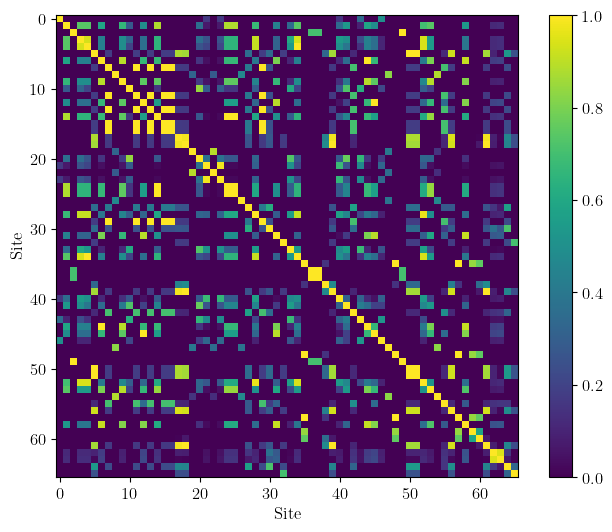

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(correlation, cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Site')
plt.show()


Sites  Adani Godda power station  Aditya Aluminium power station  \
0                       0.547535                        0.113993   
1                       0.750116                        0.056124   
2                       0.154009                        0.405902   
3                       0.663440                        0.224178   
4                       0.070617                        0.350223   
...                          ...                             ...   
49995                   0.383533                        0.777183   
49996                   0.463922                        0.726372   
49997                   0.824247                        0.970950   
49998                   0.701514                        0.241011   
49999                   0.383090                        0.596946   

Sites  Amravati Thermal Power Project  Angul power station  \
0                            0.677072             0.216191   
1                            0.880339             0.318269 

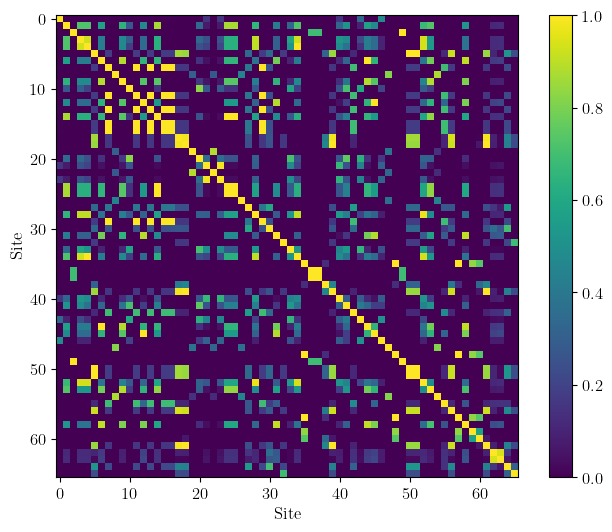

In [13]:
num_samples = 50000
# Multivariate normal with site co-occurrence matrix
means = np.zeros(correlation.shape[1])
samples = np.random.multivariate_normal(means, correlation, size=num_samples)
samples = pd.DataFrame(samples, columns=non_empty_sites)

# Transform to uniform [0, 1]
for col in samples.columns:
    cdf = stats.norm.cdf(samples[col])
    samples[col] = stats.uniform.ppf(cdf)

print(samples)

plt.figure(figsize=(8, 6))
plt.imshow(samples.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Site', fontname="times new roman", fontsize=12)
plt.ylabel('Site', fontname="times new roman", fontsize=12)
plt.savefig(f'gaussian_{sector}.png', transparent=True)
plt.show()

samples.to_parquet(f"gaussian_random_numbers_cooccurrence_india_{sector}.parquet.gzip", compression='gzip', index=False)

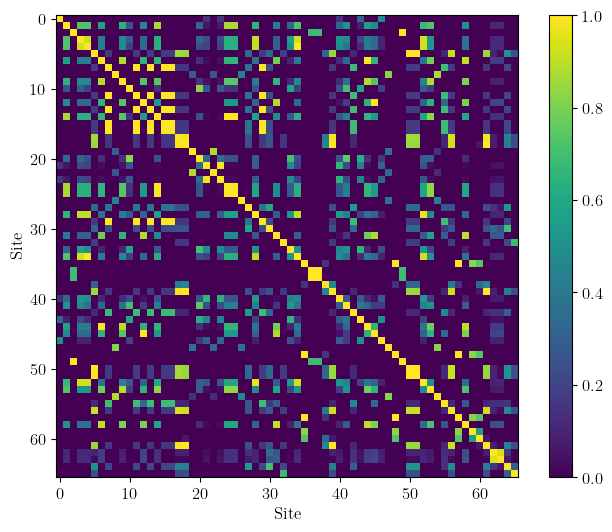

In [14]:
# here will be t-copula fitting
t_samples = {}

df = 20
corr_matrix = correlation
mu = np.zeros(len(corr_matrix))
s = stats.chi2.rvs(df=df, size=num_samples)[:, np.newaxis]
Z = np.random.multivariate_normal(mu, corr_matrix, num_samples)
X = np.sqrt(df/s)*Z
U = stats.t.cdf(X, df=df)
t_samples = pd.DataFrame(U, columns=occurrences.columns)

plt.figure(figsize=(8, 6))
plt.imshow(t_samples.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Site', fontname="times new roman", fontsize=12)
plt.ylabel('Site', fontname="times new roman", fontsize=12)
plt.savefig(f't_Copula_{sector}.png', transparent=True)

t_samples.sum(axis=1).sort_values()

t_samples.to_parquet(f"t_random_numbers_cooccurrence_india_{sector}.parquet.gzip", compression='gzip', index=False)